In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


In [2]:
!git clone https://github.com/shtapic/toxic-comment-classification.git


Cloning into 'toxic-comment-classification'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 77 (delta 28), reused 50 (delta 17), pack-reused 11 (from 1)
Receiving objects: 100% (77/77), 54.46 MiB | 25.27 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [ ]:
import os
import sys

PROJECT_DIR = "/kaggle/working/toxic-comment-classification"
os.chdir(PROJECT_DIR)

!pip install -r requirements.txt

if not os.path.exists("data"):
    os.makedirs("data")

KAGGLE_INPUT_DIR = "/kaggle/input/jigsaw-toxic-comment-classification-challenge"

!unzip -o {KAGGLE_INPUT_DIR}/train.csv.zip -d data/
!unzip -o {KAGGLE_INPUT_DIR}/test.csv.zip -d data/


Archive:  /kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
  inflating: data/train.csv          
Archive:  /kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
  inflating: data/test.csv           
Setup complete. Current working directory: /kaggle/working/toxic-comment-classification
Files in data folder: ['test.csv', 'train.csv']


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from src.preprocess_data import clean_text
from src.FastTextVectorizer import FastTextVectorizer
from src.utils import metrics_model
from src.find_optimal_threshold import find_optimal_threshold

TARGET = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
RANDOM_STATE = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

/usr/local/lib/python3.12/dist-packages/google/cloud/aiplatform/models.py:52: FutureWarning: Support for google-cloud-storage < 3.0.0 will be removed in a future version of google-cloud-aiplatform. Please upgrade to google-cloud-storage >= 3.0.0.
  from google.cloud.aiplatform.utils import gcs_utils


Using device: cuda


In [ ]:
df = pd.read_csv('data/train.csv')
df['comment_text'] = df['comment_text'].astype(str).apply(clean_text)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)


FastText_pipeline = Pipeline([
    ('fasttext', FastTextVectorizer(vector_size=300, window=3, epochs=20, min_n=3, max_n=6)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear')))
])

print("FastText training started.")
FastText_pipeline.fit(train_df['comment_text'], train_df[TARGET])
print("FastText training complete.")

FastText training started.


FastText training complete.


In [ ]:
from src.loader import ToxicDataset , create_embedding_matrix_and_vocab
MAX_LEN = 300
BATCH_SIZE = 64

embedding_matrix, word_to_idx = create_embedding_matrix_and_vocab(FastText_pipeline)


train_dataset = ToxicDataset (train_df, 'comment_text', TARGET, MAX_LEN, word_to_idx)
val_dataset = ToxicDataset (val_df, 'comment_text', TARGET, MAX_LEN, word_to_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
print("DataLoaders ready.")

Vocab size: 55756, Embedding dim: 300
DataLoaders ready.


In [7]:
from src.BiLSTM import BiLSTMClassifier
from src.train_LSTM import train_model, evaluate_model

model = BiLSTMClassifier(
    vocab_size=embedding_matrix.shape[0],
    hidden_dim=128*2,
    output_dim=len(TARGET),
    n_layers=2,
    dropout=0.3,
    embed_dim=embedding_matrix.shape[1],
    pretrained_embeddings=embedding_matrix
)

model.to(DEVICE)
print(model)

BiLSTMClassifier(
  (embedding): Embedding(55756, 300, padding_idx=0)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (clf): Linear(in_features=512, out_features=6, bias=True)
)


training
Epoch 1/5, Loss: 0.0641
Epoch 2/5, Loss: 0.0453
Epoch 3/5, Loss: 0.0414
Epoch 4/5, Loss: 0.0377
Epoch 5/5, Loss: 0.0339


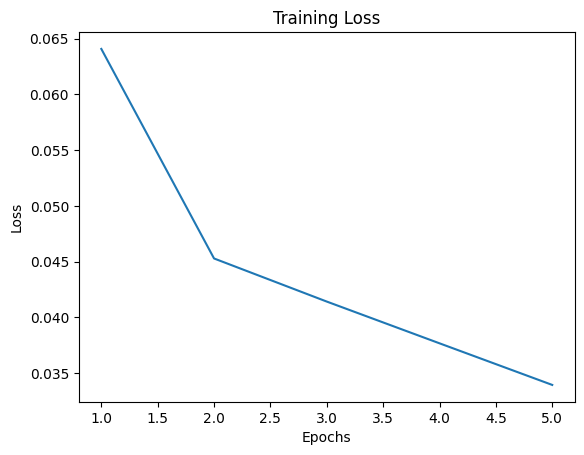


Evaluating
optimal thresholds...

Metrics with optimal thresholds:
--------------------------------
F1 Score (macro): 0.6081
F1 Score (micro): 0.7504
Accuracy: 0.9168
Precision: 0.4152
Recall: 0.6333
--------------------------------
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      3056
           1       0.39      0.66      0.49       321
           2       0.81      0.83      0.82      1715
           3       0.34      0.35      0.34        74
           4       0.73      0.74      0.73      1614
           5       0.48      0.45      0.46       294

   micro avg       0.75      0.75      0.75      7074
   macro avg       0.59      0.63      0.61      7074
weighted avg       0.76      0.75      0.75      7074
 samples avg       0.06      0.07      0.06      7074

Validation ROC-AUC Score: 0.9814


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("training")
train_model(model, train_loader, val_loader, n_epochs=5, lr=1e-3, device=DEVICE)

print("\nEvaluating")
val_labels, val_outputs_logits = evaluate_model(model, val_loader, device=DEVICE)

val_outputs = torch.sigmoid(torch.tensor(val_outputs_logits)).cpu().numpy()

print("optimal thresholds...")
best_thresholds, best_scores = find_optimal_threshold(val_labels, val_outputs)
print("\nMetrics with optimal thresholds:")
metrics_model(val_df[TARGET], val_outputs, thresholds=best_thresholds)
print(f'Validation ROC-AUC Score: {roc_auc_score(val_df[TARGET], val_outputs):.4f}')